In [1]:
import numpy
import numpy as np
import pandas
import pandas as pd
from numba import njit
import sys,glob
import zipfile, os, time
import urllib3
from datetime import datetime, timedelta
import glob
import h5py
import netCDF4 as nc
sys.path.append(os.getcwd()+'/../cds-backend/code/')
sys.path.append(os.getcwd()+'/../harvest/code/')
import rasotools
# from harvest_convert_to_netCDF_newfixes import write_dict_h5
import cds_eua3 as eua
# eua.logging_set_level(30)
import xarray as xr

import cdsapi, zipfile, os, time
#import schedule
import copy
from shutil import copyfile
import multiprocessing
import pickle

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import warnings
warnings.filterwarnings('ignore')

from inspect import getmembers, isfunction


In [2]:
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=float))

def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    se = [(None,) * 3, 0.0]
    for s in seq:
        se.append(s[0])
        se.append(s[1])#+ list(seq) +
        seq=se+[ (None,) * 3]
        cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
    return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
"rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
"rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
"rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
"rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
"rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
"rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
"rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
"rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))

cmnew=make_colormap(rgblist2)

# x,y=numpy.meshgrid(numpy.linspace(-3,3,101),numpy.linspace(-3,3,101))
# gauss=x/6+y/6
# clist=numpy.linspace(-1,1,26)
# plt.contourf(x,y,gauss,clist,cmap=cmnew)
# plt.colorbar()
# plt.show()
# print('ready')

def plt_trends(lla,pdict,var='_',bias='_', marker_size = 510, marker_shape = 's', alpha=0.8):
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (12, 8),
             'axes.labelsize': 'x-large',
             'axes.titlesize': 20,
             'xtick.labelsize':'medium',
             'ytick.labelsize':'medium'}
    pylab.rcParams.update(params)

    if 'scale' not in pdict.keys():
        pdict['scale']=1.0
    a = rasotools.plot._helpers.cost(lla[2],lla[1],lla[0])
    cost = np.sum(a)/len(a)

    ax = plt.axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
    ax._autoscaleXon = False
    ax._autoscaleYon = False

    ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines()

    plt.scatter(lla[2], lla[1], s=marker_size, alpha=alpha,
                c= lla[0],
                cmap=cmnew,
                vmin=-pdict['scale'],
                vmax=pdict['scale'],
                marker = marker_shape,
                edgecolor='k',)
    plt.colorbar(orientation='horizontal', label='Trend '+pdict['units'], shrink=0.9, pad=0.05)
    plt.tight_layout()
    plt.title('Brightness Temperature ' + str(pdict['start'])+'-'+str(pdict['stop'])+', '+str(pdict['pl'])+'\n'+'trend heterogeneity cost function: '+'{:.2f}'.format(cost)+'\n'+'number of stations: '+str(len(lla[0])))
        
    try:
        os.mkdir('plots_new')
    except:
        pass
#     plt.savefig('plots_new/cuon_'+names[bias]+'_'+str(pdict['start'])+'-'+str(pdict['stop'])+'_'+str(pdict['pl']), bbox_inches='tight')
    plt.show()
    plt.close()



pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [12, 8]

def plot_world_map(file, mission_channel, marker_size = 510, marker_shape = 's', alpha = 0.8):
    trends = pickle.load( open( file, "rb" ) )
    lats = []
    lons = []
    vals = []
    minl = []
    maxl =[]

    for i in trends:
        if trends[i] >= 15:
            maxl.append([i, trends[i]])
        elif trends[i] <= -15:
            minl.append([i, trends[i]])
        else:
            lats.append(float(trends[i].lat))
            lons.append(float(trends[i].lon))
            vals.append(float(trends[i].values))
    # print(' --- dropped ---')
    # print(maxl)
    # print(minl)
    # /10. for K/10a
    plt_trends(np.array([np.array(vals)/10., np.array(lats), np.array(lons)]), dict(var='temperature',pl=mission_channel,start='2007',stop='2020',units=r'K/10a'), marker_size = marker_size, marker_shape = marker_shape, alpha=alpha)
#     rasotools.plot.map.points(lon=np.array(lons), lat=np.array(lats), values=np.array(vals), vmin=-5, vmax=5)
    plt.show()
    plt.close()

In [3]:
Image(url= "https://images.remss.com/figures/measurements/upper-air-temperature/wt_func_plot_for_web_2012.all_channels2.png")

NameError: name 'Image' is not defined

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://www.researchgate.net/publication/288057091/figure/fig1/AS:614162849878021@1523439242142/The-weighting-functions-for-the-satellite-Microwave-Sounding-Unit-MSU-and-the.png")

In [ ]:
# # lowres = glob.glob('/mnt/jetfs/scratch/uvoggenberger/rttov_out/gpsro_20231114/*.nc')
# highres = glob.glob('/mnt/jetfs/scratch/uvoggenberger/rttov_out/gpsro_all_levels/*.nc')

# print(highres[0])
# df = xr.open_dataset(highres[0], decode_times=False).to_dataframe()
# df.datum.drop_duplicates()[0,0,0,0,0]

# time_series = {}
# for targetlon in range(-180,185,5):
#     for targetlat in range(-90,95,5):
#         time_series[str(targetlat) + '_' + str(targetlon)] = [[],[],[],[]]

# for date in highres[:]:
#     df = xr.open_dataset(date, decode_times=False).to_dataframe()
#     sel_df = df.loc(axis=0)[:, :, [0], :, [0]]
#     for lat_lon in sel_df.drop_duplicates(['lat', 'lon'])[['lat', 'lon']].values:
#         single_df = sel_df[np.logical_and(sel_df.lat == lat_lon[0], sel_df.lon == lat_lon[1])]
#         # display(single_df)
#         ts_index = str(int(lat_lon[0])) + '_' + str(int(lat_lon[1]))
#         time_series[ts_index][0].append(single_df[single_df.press == 2].montemp.values)
#         time_series[ts_index][1].append(single_df[single_df.press == 3].montemp.values)
#         time_series[ts_index][2].append(single_df[single_df.press == 4].montemp.values)
#         time_series[ts_index][3].append(single_df[single_df.press == 2].datum.values)

# trends_ch3 = {}
# trends_ch4 = {}
# trends_ch5 = {}
# for lat_lon in time_series.keys():
#     if len(time_series[lat_lon][0]) < 1:
#         continue
#     df = pandas.DataFrame(np.transpose(
#         [np.array(time_series[lat_lon][0]).flatten(), 
#          np.array(time_series[lat_lon][1]).flatten(), 
#          np.array(time_series[lat_lon][2]).flatten(), 
#          np.array(time_series[lat_lon][3]).flatten(), 
#          [int(lat_lon.split('_')[0])]*len(time_series[lat_lon][0]), 
#          [int(lat_lon.split('_')[1])]*len(time_series[lat_lon][0])]
#          ), columns=['ch3', 'ch4', 'ch5', 'time', 'lat', 'lon'])
#     df.time = [pd.to_datetime('1900-01-01') + pd.Timedelta(x, 'd') for x in df.time]
#     filter_array = np.abs(df.ch3 - df.ch4) < 0.5
#     df.ch3[filter_array] = np.nan
#     df.ch4[filter_array] = np.nan
#     df.ch5[filter_array] = np.nan
#     df = df.dropna()

#     xdf = df.set_index(['lat', 'lon', 'time']).to_xarray()
#     trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3,only_slopes=True)*len(df.time)*12.*10.)
#     trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4,only_slopes=True)*len(df.time)*12.*10.)
#     trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5,only_slopes=True)*len(df.time)*12.*10.)

# pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch2_highres.p", "wb" ) )
# pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch3_highres.p", "wb" ) )
# pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/gpsro_ch4_highres.p", "wb" ) )

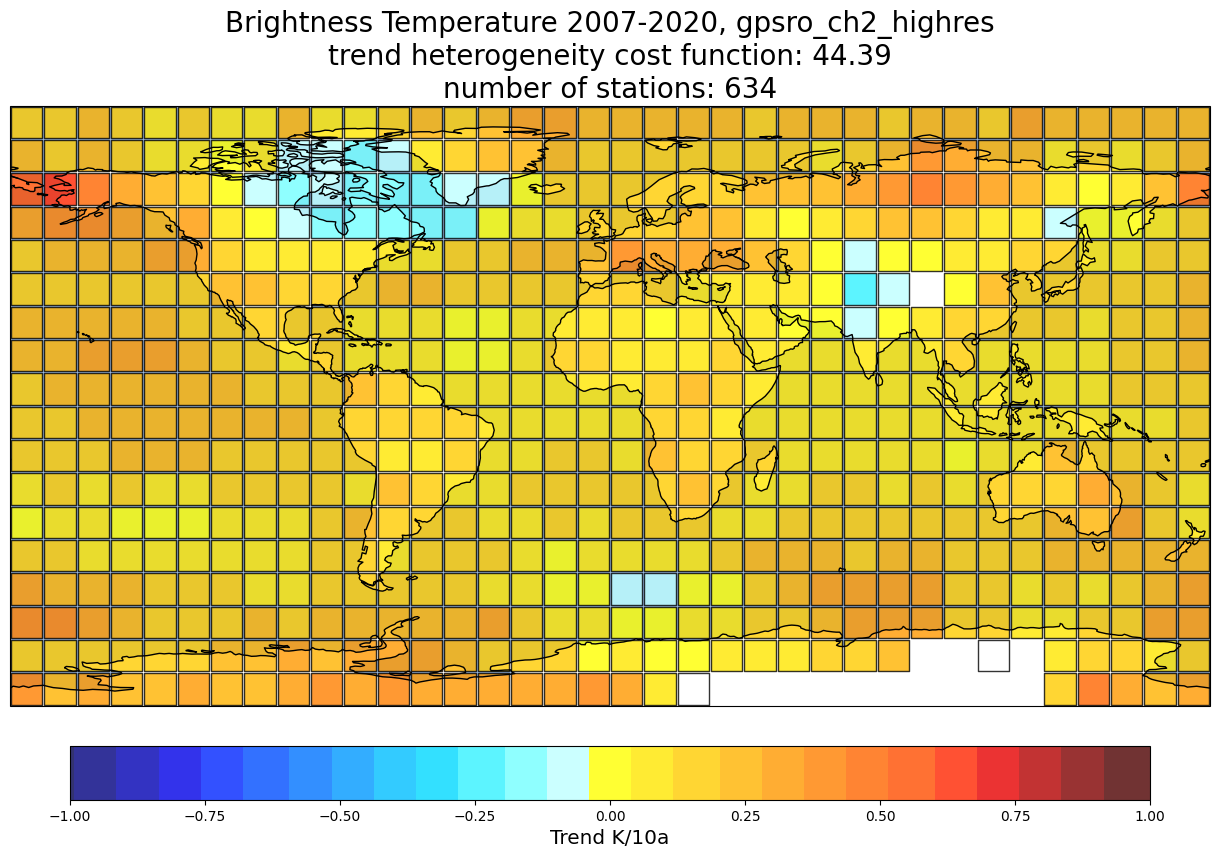

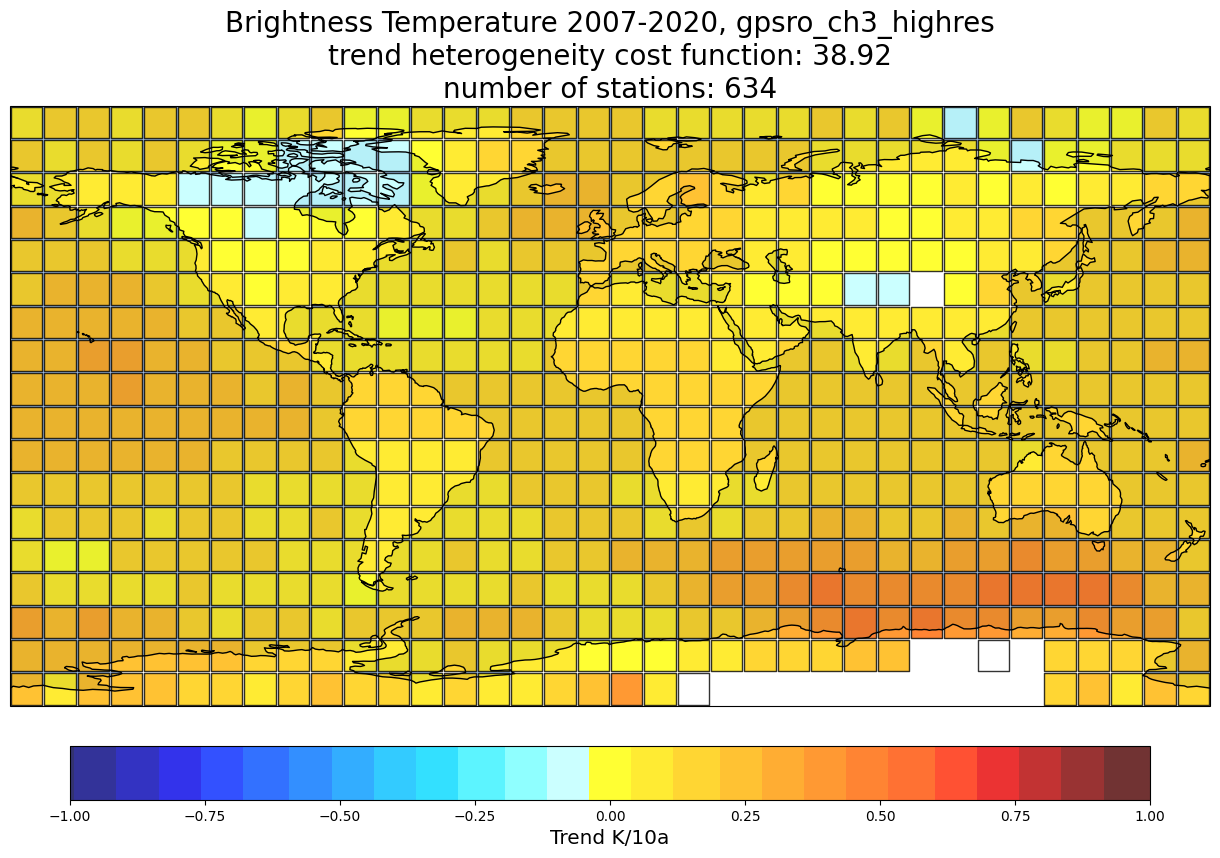

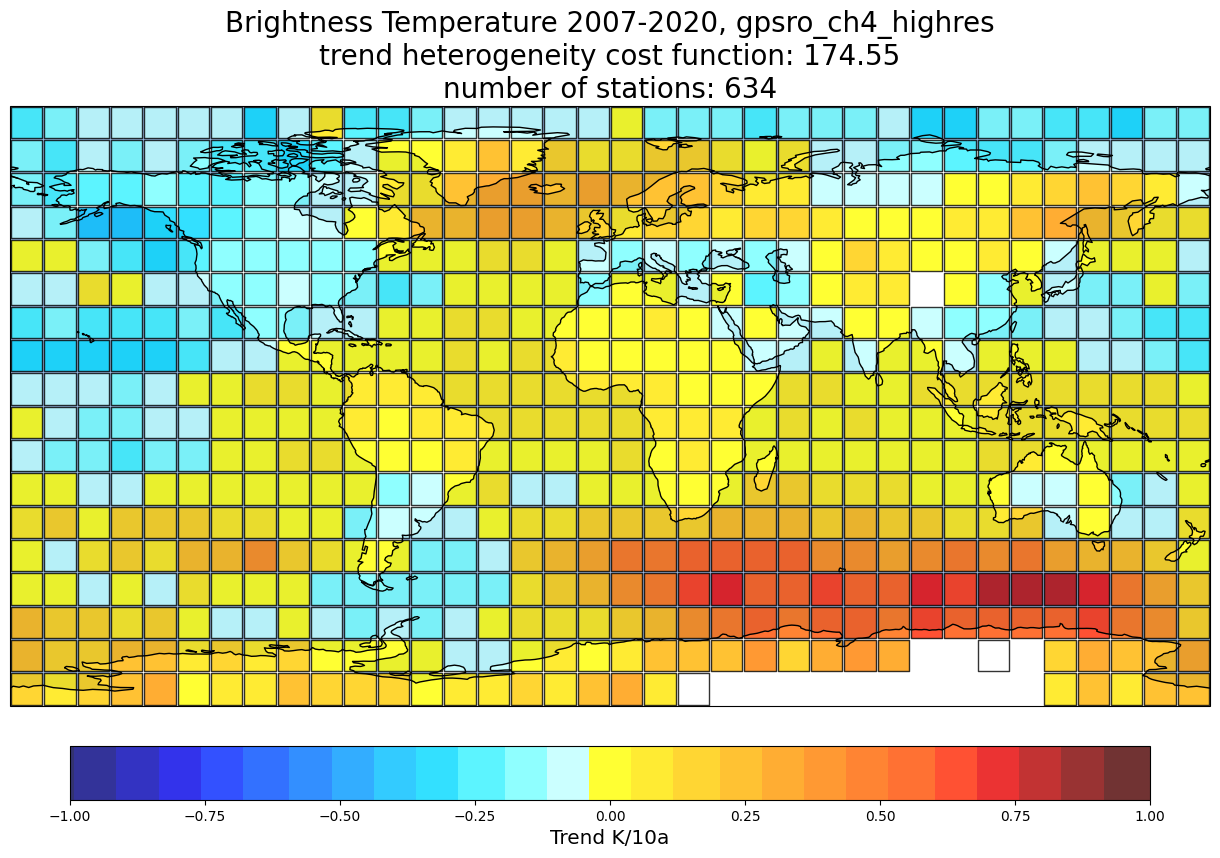

In [ ]:
for k in ['ch2', 'ch3', 'ch4']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/gpsro_worldmap/*'+k+'_highres.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0])


In [ ]:
# uah_data = rasotools.additions.allrasotrends.read_uah('/users/staff/leo/fastscratch/MSUUAHDaten/', '6.0',startyear=1978, endyear=2020)[0]
# print(np.shape(uah_data))
# display(uah_data[2,348:,3,3])

# lats = np.array(range(-8875,+9125, 250))/100.
# # lats = lats[lats != 0]
# print(len(lats), lats)
# lons = np.array(range(125, 36000, 250))/100.
# print(len(lons), lons)

# time_series = {}
# for targetlon in lons:
#     for targetlat in lats:
#         time_series[str(targetlat) + '_' + str(targetlon)] = [[],[],[],[]]

# for lat in range(len(lats)):
#     for lon in range(len(lons)):
#         ts_index = str(float(lats[lat])) + '_' + str(float(lons[lon]))
#         time_series[ts_index][0] = uah_data[0,348:,lat, lon] 
#         time_series[ts_index][1] = uah_data[1,348:,lat, lon] 
#         time_series[ts_index][2] = uah_data[3,348:,lat, lon] 
#         time_series[ts_index][3] = np.array(range(len(uah_data[3,348:,10, 10])))*30

# trends_ch3 = {}
# trends_ch4 = {}
# trends_ch5 = {}
# for lat_lon in time_series.keys():
#     if len(time_series[lat_lon][0]) < 1:
#         continue
#     df = pandas.DataFrame(np.transpose(
#         [np.array(time_series[lat_lon][0]).flatten(), 
#          np.array(time_series[lat_lon][1]).flatten(), 
#          np.array(time_series[lat_lon][2]).flatten(), 
#          np.array(time_series[lat_lon][3]).flatten(), 
#          [float(lat_lon.split('_')[0])]*len(time_series[lat_lon][0]), 
#          [float(lat_lon.split('_')[1])]*len(time_series[lat_lon][0])]
#          ), columns=['ch3', 'ch4', 'ch5', 'time', 'lat', 'lon'])
#     df.time = [pd.to_datetime('2007-01-01') + pd.Timedelta(x, 'd') for x in df.time]
#     # df.replace(-99.99, np.nan, inplace=True)
#     # filter_array = np.abs(df.ch3 - df.ch4) < 0.5
#     # df.ch3[filter_array] = np.nan
#     # df.ch4[filter_array] = np.nan
#     # df.ch5[filter_array] = np.nan
#     df = df.dropna()

#     xdf = df.set_index(['lat', 'lon', 'time']).to_xarray()
#     trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)
#     trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)
#     trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)

# pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/uah_worldmap/uah_ch2.p", "wb" ) )
# pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/uah_worldmap/uah_ch3.p", "wb" ) )
# pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/uah_worldmap/uah_ch4.p", "wb" ) )

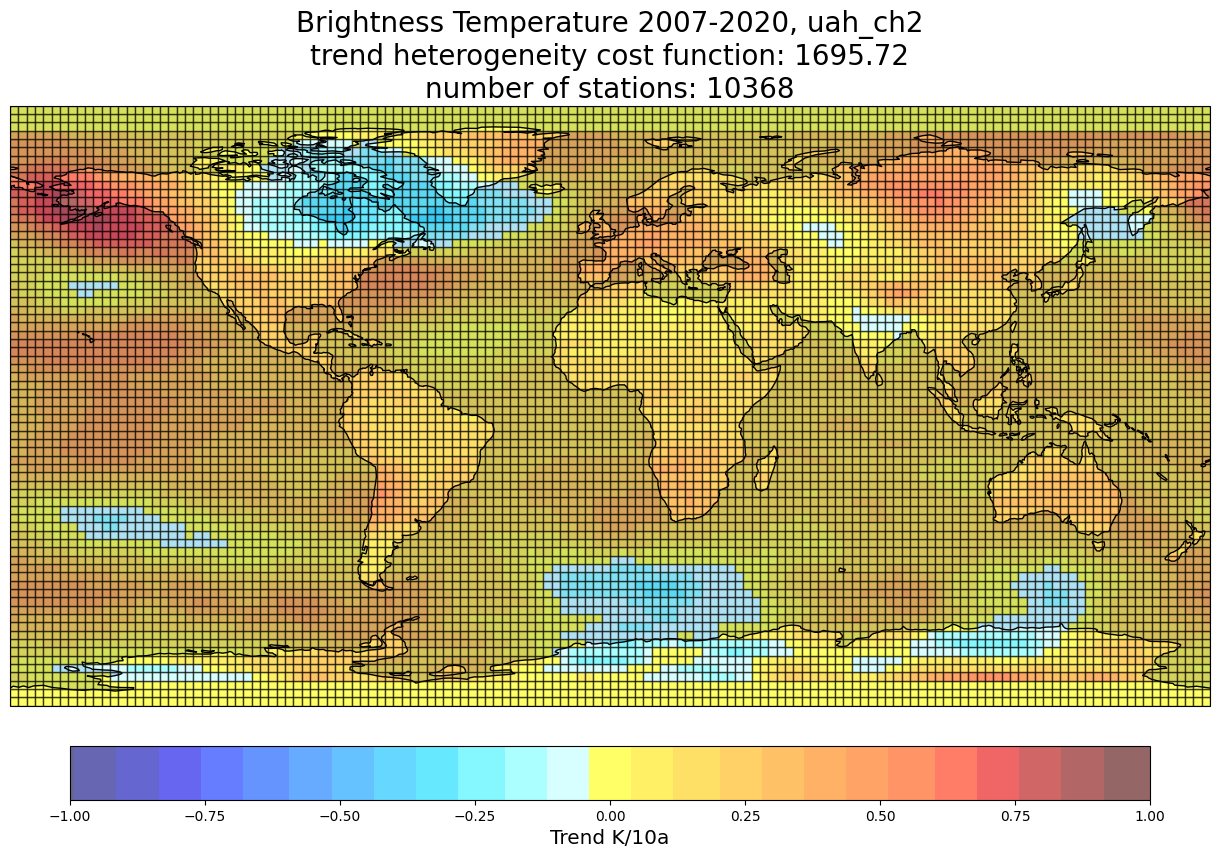

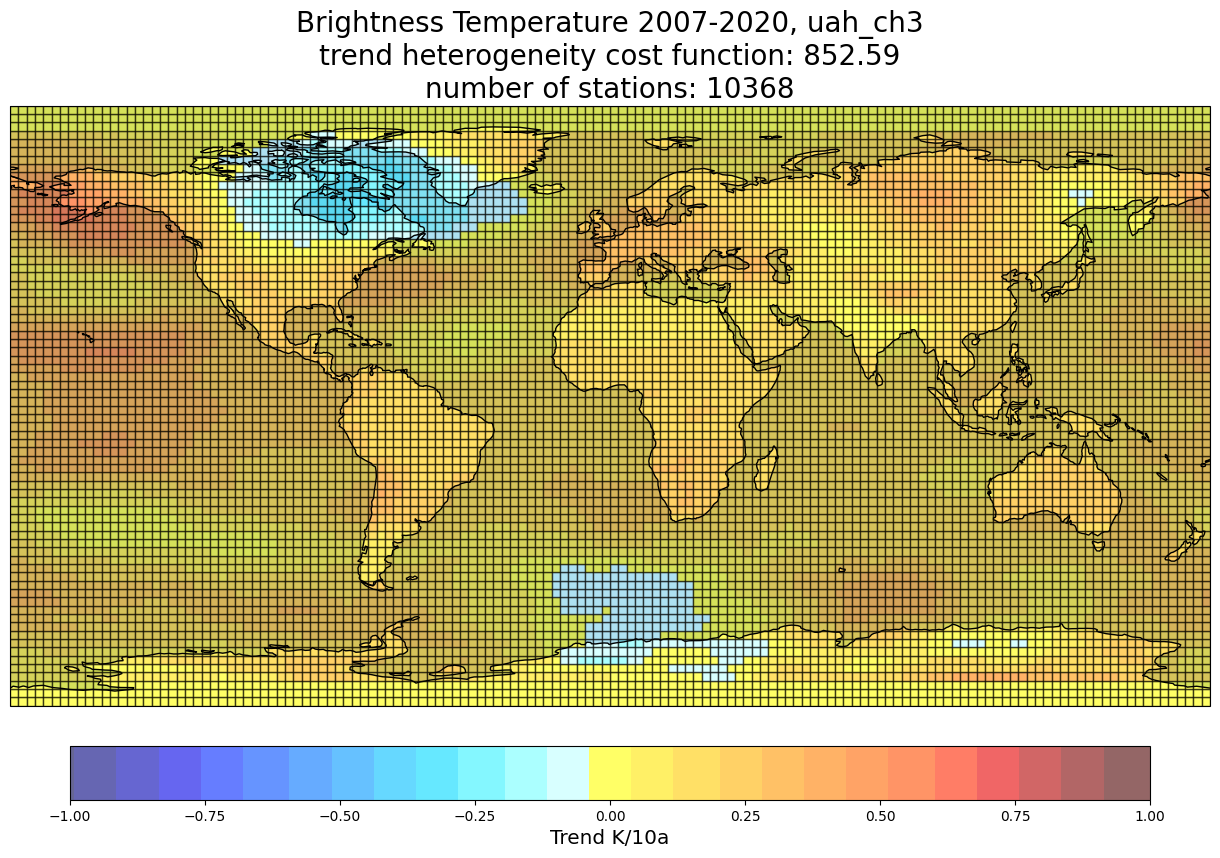

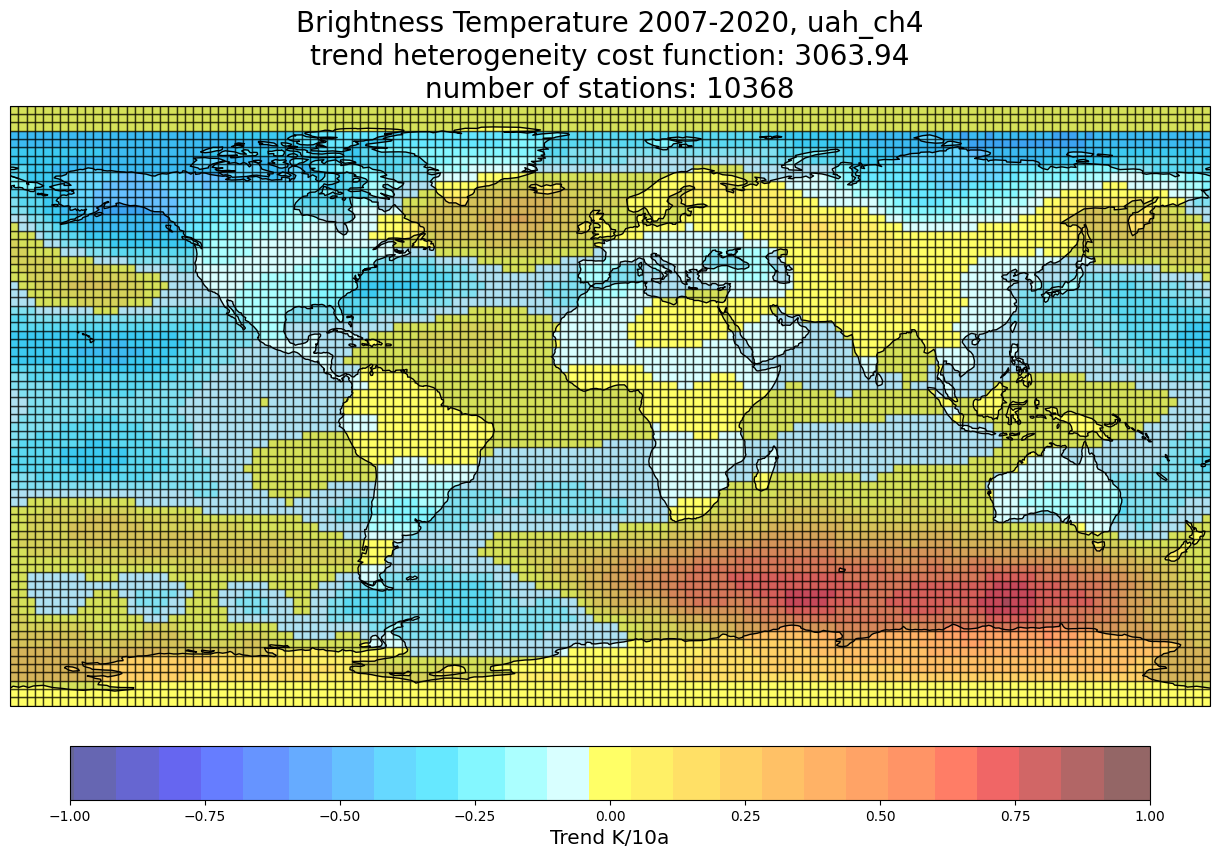

In [ ]:
for k in ['ch2', 'ch3', 'ch4']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/uah_worldmap/*'+k+'.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 35, marker_shape = 's', alpha = 0.6 )

In [ ]:
# lats = np.array(range(-8875,+9125, 250))/100.
# # lats = lats[lats != 0]
# print(len(lats), lats)
# lons = np.array(range(125, 36000, 250))/100.-180.
# print(len(lons), lons)

# fnlist = ['NESDIS-STAR_TCDR_MSU-AMSUA_V03R00_TMT_S197811_E202212_C20230104.nc', '/NESDIS-STAR_TCDR_MSU-AMSUA_V03R00_TUT_S198101_E202212_C20230104.nc',  'NESDIS-STAR_TCDR_MSU-AMSUA_V03R00_TLS_S197811_E202212_C20230104.nc']
# star_data = rasotools.additions.allrasotrends.read_star('/users/staff/leo/fastscratch/MSU_STAR/', fnlist, startyear=1978, endyear=2020)
# star_data = star_data[0]
# np.shape(star_data)

# time_series = {}
# for targetlon in lons:
#     for targetlat in lats:
#         time_series[str(targetlat) + '_' + str(targetlon)] = [[],[],[],[]]

# for lat in range(len(lats)):
#     for lon in range(len(lons)):
#         ts_index = str(float(lats[lat])) + '_' + str(float(lons[lon]))
#         time_series[ts_index][0] = star_data[1,348:,lat, lon] 
#         time_series[ts_index][1] = star_data[2,348:,lat, lon] 
#         time_series[ts_index][2] = star_data[3,348:,lat, lon] 
#         time_series[ts_index][3] = np.array(range(len(star_data[3,348:,10, 10])))*30

# trends_ch3 = {}
# trends_ch4 = {}
# trends_ch5 = {}
# for lat_lon in time_series.keys():
#     if len(time_series[lat_lon][0]) < 1:
#         continue
#     df = pandas.DataFrame(np.transpose(
#         [np.array(time_series[lat_lon][0]).flatten(), 
#          np.array(time_series[lat_lon][1]).flatten(), 
#          np.array(time_series[lat_lon][2]).flatten(), 
#          np.array(time_series[lat_lon][3]).flatten(), 
#          [float(lat_lon.split('_')[0])]*len(time_series[lat_lon][0]), 
#          [float(lat_lon.split('_')[1])]*len(time_series[lat_lon][0])]
#          ), columns=['ch3', 'ch4', 'ch5', 'time', 'lat', 'lon'])
#     df.time = [pd.to_datetime('2007-01-01') + pd.Timedelta(x, 'd') for x in df.time]
#     # df.replace(-99.99, np.nan, inplace=True)
#     # filter_array = np.abs(df.ch3 - df.ch4) < 0.5
#     # df.ch3[filter_array] = np.nan
#     # df.ch4[filter_array] = np.nan
#     # df.ch5[filter_array] = np.nan
#     df = df.dropna()
#     if len(df) < 10:
#         print('skipped: ', lat_lon)
#         continue


#     xdf = df.set_index(['lat', 'lon', 'time']).to_xarray()
#     trends_ch3[lat_lon] = (rasotools.met.time.trend(xdf.ch3, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)
#     trends_ch4[lat_lon] = (rasotools.met.time.trend(xdf.ch4, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)
#     trends_ch5[lat_lon] = (rasotools.met.time.trend(xdf.ch5, only_slopes=True, method='polyfit')*len(df.time)*12.*10.)

# pickle.dump( trends_ch3, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/star_worldmap/star_ch2.p", "wb" ) )
# pickle.dump( trends_ch4, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/star_worldmap/star_ch3.p", "wb" ) )
# pickle.dump( trends_ch5, open( "/users/staff/uvoggenberger/scratch/RTTOV_output/star_worldmap/star_ch4.p", "wb" ) )

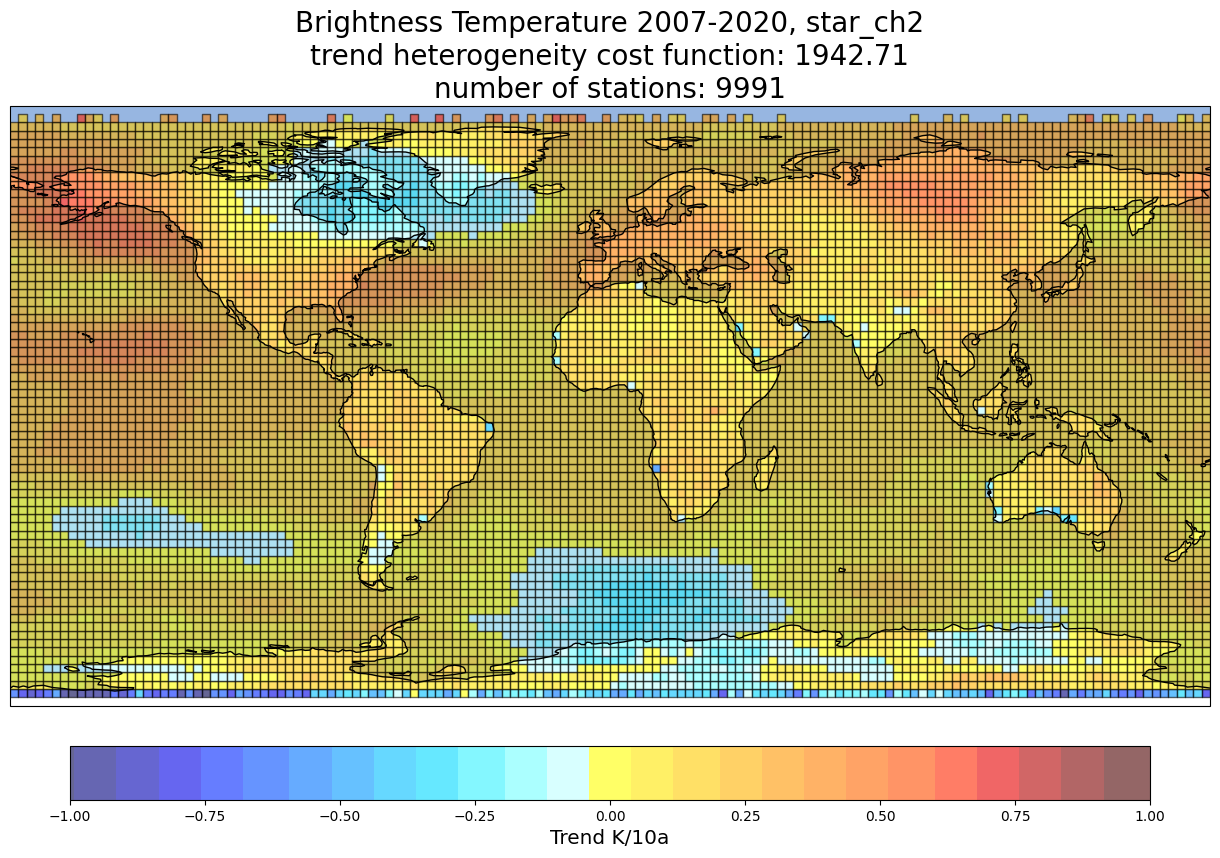

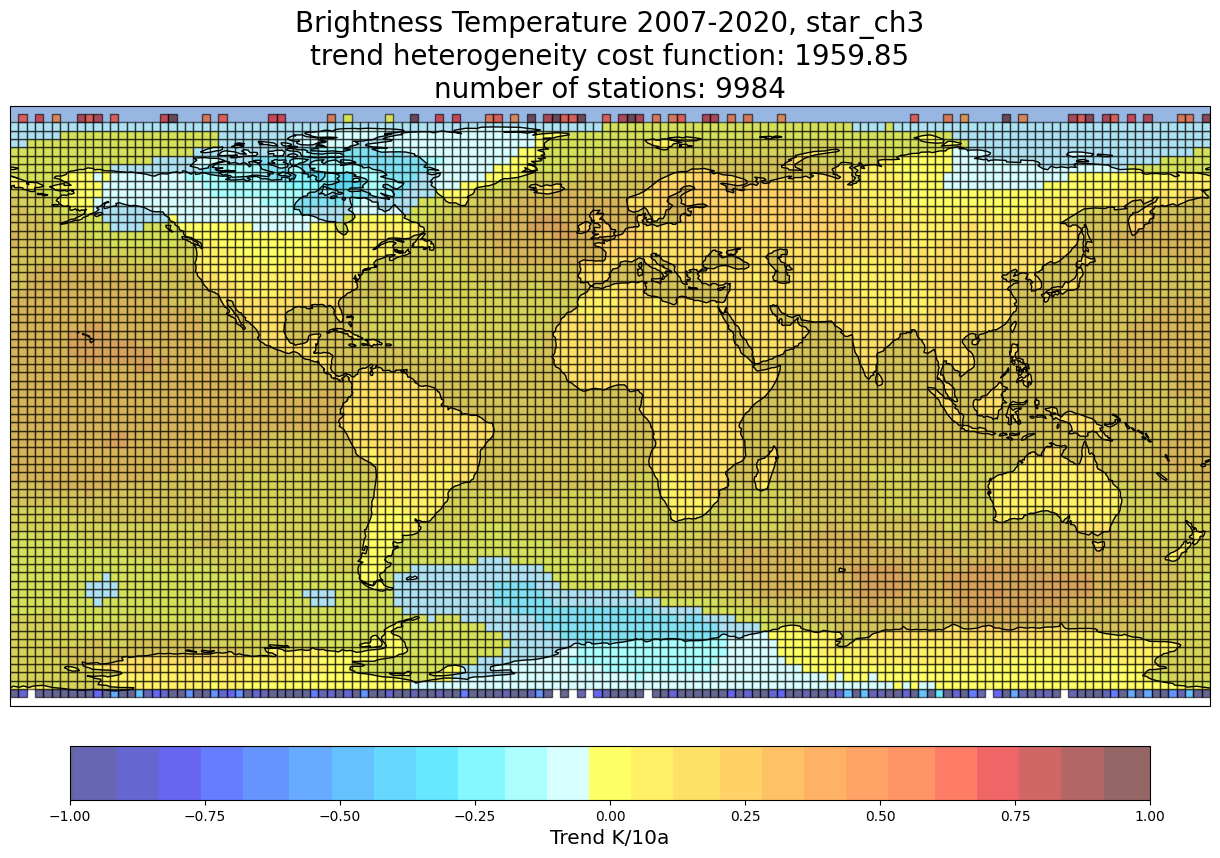

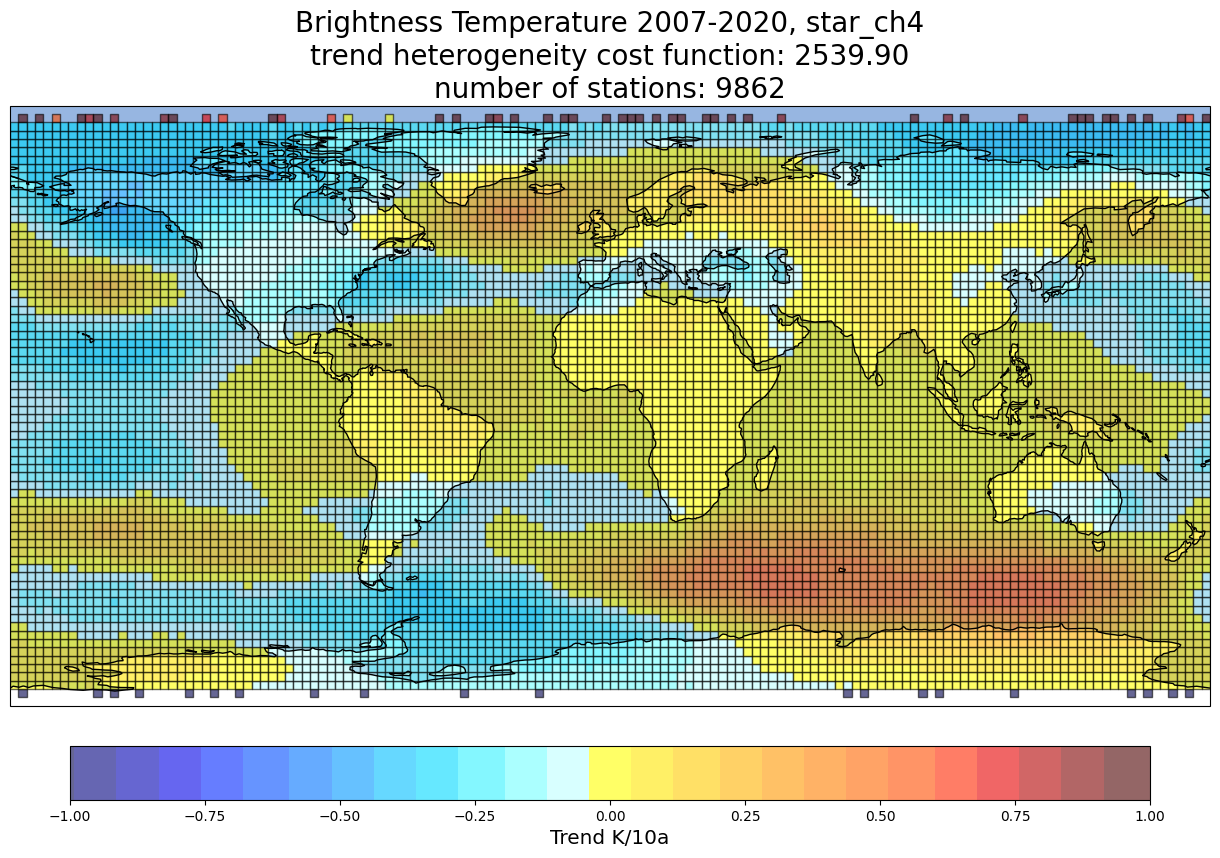

In [ ]:
for k in ['ch2', 'ch3', 'ch4']:
    files = glob.glob('/users/staff/uvoggenberger/scratch/RTTOV_output/star_worldmap/*'+k+'.p')
    files = np.sort(files)
    for i in files:
        plot_world_map(i, i.split('/')[-1].split('.')[0], marker_size = 35, marker_shape = 's', alpha = 0.6 )